InstaDeep ML test <br>
Author: Mously Diaw

# Protein sequence classification

Proteins are sequence of amino acids, which can be encoded by a single letter. This project aims at building a deep learning model that assigns amino acid sequences to their protein family. The [Pfam dataset](https://www.kaggle.com/googleai/pfam-seed-random-split) is used for this task. <br>

In this notebook, I built a classifier that predicts to which family amongst the 429 most frequent protein families an amino acid sequence belongs. The classifier is a simple model with only 3 layers that yielded an accuracy of ~98% on the test set. The notebook is divided as follows:

1. [Dataset analysis](#section-one) <br>
2. [Classifier](#section-two) <br> 

<a id="section-one"></a>
# 1. Dataset analysis 

## 1.1. Loading the data

In [127]:
%matplotlib inline
import os
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical 
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder 
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

In [ ]:
def load_data(partition,col_list):
    data = []
    for fn in os.listdir(os.path.join(data_path, partition)):
        with open(os.path.join(data_path, partition, fn)) as f:
            data.append(pd.read_csv(f, index_col=None,usecols=col_list))
    return pd.concat(data) 

We wish to predict protein families (*family_accession*) given amino acid sequences (*sequence*) so we will focus on these two attributes.

In [ ]:
data_path = '../input/pfam-seed-random-split/random_split/random_split/'
col_list = ["family_accession","sequence"]
df_train = load_data('train',col_list)
df_val = load_data('dev',col_list)
df_test = load_data('test',col_list)

In [129]:
print('Data size:')
print('Train size :', len(df_train))
print('Val size :', len(df_val))
print('Test size :', len(df_test))

Data size:
Train size : 1086741
Val size : 126171
Test size : 126171


In [175]:
df_train.head()

,family_accession,sequence
0,PF08891.11,IEFEEKMLELIDARIESASDDELFAGGYLRGHISLSVANCEEQGIN...
1,PF01033.17,TTCAVRGCSDINLNQNCQCDPSCYSFGDCCADFAAVCESS
2,PF01805.20,RNIIDKLAQFVARNGPEFEQMTKNKQKDNPKFSFLFGGEYFNYYQYKVT
3,PF06799.11,AVPREQRPVNELQQLKDTPLLAWATLDLPQYAQRLLILYGGVFLLL...
4,PF15494.6,GPNFILEVYSPVSQTWYPVCQDDWTDDFGKIACEDMGYNVDTYYYS...


## 1.2. Exploratory data analysis (EDA) and data pre-processing

### 1.2.1. Preliminary processing and EDA

Let's first merge the data.

In [ ]:
frames = [df_train, df_val, df_test]
df_full = pd.concat(frames)

In [130]:
print('Total number of unique protein families:',len(df_full.family_accession.unique()))

Total number of unique protein families: 17929


In [131]:
family_counts = df_full.family_accession.value_counts()

In [134]:
print("5 most frequent protein families:" + "\n",family_counts[0:5])

5 most frequent protein families:
 PF13649.6     4545
PF00560.33    2407
PF13508.7     2199
PF06580.13    1921
PF02397.16    1908
Name: family_accession, dtype: int64


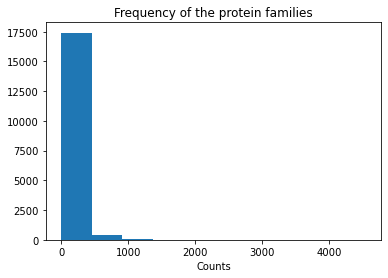

In [135]:
plt.hist(family_counts) 
plt.title("Frequency of the protein families")
plt.xlabel("Counts")
plt.show() 

Majority of the protein families have less than 500 instances. In the remainder of the notebook, we will focus on those that have 500 or more instances.

In [136]:
freq_families = family_counts[family_counts>500]

In [140]:
df_partial = df_full.loc[df_full['family_accession'].isin(freq_families.index.tolist())]
print("The partial data set has %s instances." % len(df_partial))

The partial data set has 334045 instances.


In [141]:
num_classes = len(df_partial.family_accession.unique())
print('Number of unique protein families in the partial data set:',num_classes)

Number of unique protein families in the partial data set: 429


We will now compute the number of occurences of each amino acid and the length of the sequences in the data set.

In [ ]:
# Count frequency amino acids
keys = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L','M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y','X', 'U', 'B', 'O', 'Z']

d = {key: 0 for key in keys}
for sequence in df_partial.sequence:     
    for char in sequence: 
        d[char] = d[char] + 1 

# Order by frequency 
d_sorted = sorted(((d[key],key) for key in d), reverse =True) 

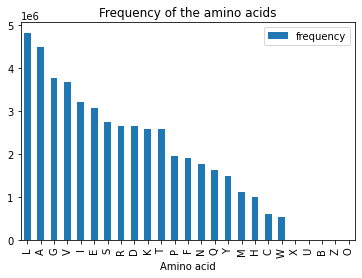

In [176]:
df_freq = pd.DataFrame(d_sorted, columns=['frequency', 'Amino acid'])
df_freq.plot(kind='bar', x='Amino acid')
plt.title("Frequency of the amino acids")
plt.show() 

We can see that there are 20 common amino acids. X,U,Z,B,O are the least frequent. 

In [156]:
sequence_length = [len(sequence) for sequence in df_partial.sequence]
print("Sequence length ranges from %s to %s." % (np.min(sequence_length),np.max(sequence_length)))
print("The median is %s." % int(np.median(sequence_length)))

Sequence length ranges from 12 to 1182.
The median is 113.


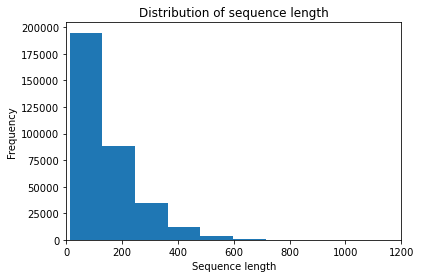

In [152]:
plt.hist(sequence_length)
plt.xlabel('Sequence length')
plt.ylabel('Frequency')
plt.title('Distribution of sequence length') 
plt.xlim(0, 1200) 
plt.show()

### 1.2.2. Sequence processing and data splitting

Before feeding the data to a neural network, the sequences must be converted into tensors. I chose to tokenize the sequences by breaking them into characters. I then vectorized them (convert each character to a number) using a dictionary with the 20 most common amino acids; the 5 least frequent ones are affected the value '21'. After vectorization, I brought all sequences to the same length (100) before integer encoding them. 

In [157]:
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L','M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
    """
    Creates dictionary that assigns each amino acid to a number
    """
    char_dict = {}
    for index, val in enumerate(codes):
        char_dict[val] = index+1
    return char_dict

char_dict = create_dict(amino_acids)

print("Dictionary:", char_dict)

Dictionary: {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}


In [ ]:
def vectorized_sequence(sequence):
    """
    Encodes the sequence using predefined dictionary. The 5 least frequent amino acids are affected the value '21'
    """
    code = []
    l = [char for char in sequence]
    for char in l:
        code.append(char_dict.get(char, 21))    
    return code   

Let's illustrate the sequence processing with the following sequence.

In [158]:
idx=90
print("Amino acid sequence:",df_partial.sequence.iloc[idx])

Amino acid sequence: KDSTTIDTIRVKYLGKKGELTTILRGMGSLSKEERPIVGKLANEVREVLEAELEAITKAVKEAEKQEKL


In [ ]:
vectorized_sequences = [vectorized_sequence(sequence) for sequence in df_partial.sequence]  

In [159]:
print("Vectorized sequence:", vectorized_sequences[idx])

Vectorized sequence: [9, 3, 16, 17, 17, 8, 3, 17, 8, 15, 18, 9, 20, 10, 6, 9, 9, 6, 4, 10, 17, 17, 8, 10, 15, 6, 11, 6, 16, 10, 16, 9, 4, 4, 15, 13, 8, 18, 6, 9, 10, 1, 12, 4, 18, 15, 4, 18, 10, 4, 1, 4, 10, 4, 1, 8, 17, 9, 1, 18, 9, 4, 1, 4, 9, 14, 4, 9, 10]


In [ ]:
maxlen = 100
padded_sequences = pad_sequences(vectorized_sequences , maxlen=maxlen, padding='post')

In [160]:
print("Padded sequence:", padded_sequences[idx])

Padded sequence: [ 9  3 16 17 17  8  3 17  8 15 18  9 20 10  6  9  9  6  4 10 17 17  8 10
 15  6 11  6 16 10 16  9  4  4 15 13  8 18  6  9 10  1 12  4 18 15  4 18
 10  4  1  4 10  4  1  8 17  9  1 18  9  4  1  4  9 14  4  9 10  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


Finally, I transformed the labels by integer encoding. 

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_partial.family_accession) 

Let's now split the partial data into training, validation and test sets.

In [ ]:
X = padded_sequences
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [162]:
print("Train size:",len(X_train))
print("Val size:",len(X_val))
print("Test size:",len(X_test))

Train size: 270576
Val size: 30064
Test size: 33405


<a id="section-two"></a>
# 2. Classifier 

To train the model, I will load the data in batches by creating a data iterator. 

In [163]:
class DataIterator:
    """ Collects data and yields bunch of batches of data
    Takes data sets and batch_size as arguments """
    def _init_(self, data1,data2, batch_size,iters):
        self.data1 = data1
        self.data2 = data2
        self.batch_size = batch_size
        self.iter = iters
        
    def next_batch(self):
        try:
            idxs = next(self.iter)
        except StopIteration:
            self.iter = self.make_random_iter()
            idxs = next(self.iter)
        X =[self.data1[i] for i in idxs]
        Y =[self.data2[i] for i in idxs]
        X = np.array(X)
        Y = np.array(Y)
        return X, Y
    
    def make_random_iter(self):
        splits = np.arange(self.batch_size, len(self.data1),self.batch_size)
        it = np.split(np.random.permutation(range(len(self.data1))), splits)[:-1]
        return iter(it)

In [164]:
def train_val_model(model,epochs,X_train,y_train,batch_size,X_val,y_val):
    """
    Returns accuracy and loss for training and validation data at each epoch. 
    Takes model, data sets and batch_size in argument
    """
    train_iter = DataIterator() 
    train_iter.data1 = X_train
    train_iter.data2 = y_train
    train_iter.batch_size = batch_size
    train_iter.iter = train_iter.make_random_iter()
    training_iters = np.ceil(len(y_train)/train_iter.batch_size)
    acc_epochs =[]
    loss_epochs = []
    val_acc_epochs =[]
    val_loss_epochs = []
    for epoch in range(epochs):  
        print("\n" + "Epoch:",epoch)
        step = 0
        acc = 0
        loss = 0
        val_acc = 0
        val_loss = 0
        while  step  <= training_iters:
            batch_x, batch_y = train_iter.next_batch()
            history = model.fit(batch_x, batch_y , epochs=1,batch_size= train_iter.batch_size, 
                            validation_data=(X_val, y_val),verbose = False) 
            acc += history.history['accuracy'][0] 
            loss += history.history['loss'][0]
            val_acc += history.history['val_accuracy'][0]
            val_loss += history.history['val_loss'][0]
            step += 1
            if step % 50 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.4f"
                    % (step, history.history['loss'][0])
                )
                print("Seen so far: %s samples" % ((step) * train_iter.batch_size))
        acc_epochs.append(acc/training_iters) 
        loss_epochs.append(loss/training_iters) 
        val_acc_epochs.append(val_acc/training_iters)
        val_loss_epochs.append(val_loss/training_iters)
    return [acc_epochs,loss_epochs,val_acc_epochs,val_loss_epochs]

Let's train the following 3-layered model.

In [ ]:
model = Sequential([
    Embedding(22, 8, input_length=maxlen),  
    Flatten(),   
    Dense(num_classes, activation ='softmax') 
]) 

In [165]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 8)            176       
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 429)               343629    
Total params: 343,805
Trainable params: 343,805
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
epochs = 15
batch_size = 512
acc_loss = train_val_model(model,epochs,X_train,y_train,batch_size,X_val,y_val)

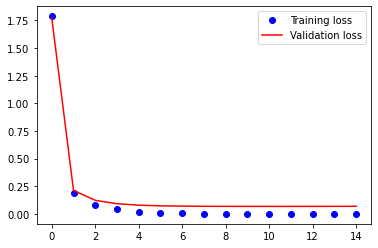

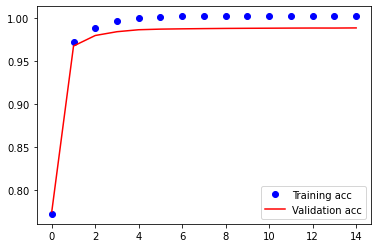

In [166]:
epochs = range(1, len(acc_loss) + 1) 
plt.plot(acc_loss[1], 'bo', label='Training loss')  
plt.plot(acc_loss[3], 'r', label='Validation loss')
plt.legend() 
plt.figure() 
plt.plot(acc_loss[0], 'bo', label='Training acc') 
plt.plot(acc_loss[2], 'r', label='Validation acc') 
plt.legend() 
plt.show() 

The number of epochs can be reduced to 6 since beyond that value there is no improvment in loss and accuracy. The validation loss is only slighty above the training loss, which means that there is neither underfitting nor overfitting.  

In [171]:
results = model.evaluate(X_test, y_test) 

1044/1044 [==============================] - 2s 2ms/step - loss: 0.0720 - accuracy: 0.9862


In [174]:
print("Test loss: %s, Test accuracy: %s" % (results[0],results[1]))

Test loss: 0.07195643335580826, Test accuracy: 0.9862295985221863


Though simple, the model yields a loss of ~0.07 and an accuracy of ~98% on the test set. Future improvements could involve modifying the sequence processing by using NLP techniques for instance and adding more layers like RNNs to the model. I would also attempt training more data to predict the remaining protein families.